In [1]:
import json, os, sys

from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    
import utils
import result_helper


sns.set(style="whitegrid")

In [2]:
def add_combined_mean_std(df: pd.DataFrame, attr: str, g_format: bool=False):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.2f} ({std:0.3f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)

In [3]:
job_paths = Path("../data/experiments-skadi/").glob("**/job-info.json")
job_paths = filter(lambda p: "/pp/" in str(p), job_paths)
job_paths = list(job_paths)

df_data = result_helper.get_result_summary(job_paths)

In [4]:
df_data["p_add"] = (df_data["p"] - df_data["q"]).round(2)

In [5]:
df_grouped = df_data.groupby(["n_steps", "k", "q", "p_add", "p"])[["accuracy_score"]].agg(
    accuracy_mean=("accuracy_score", "mean"),
    accuracy_std=("accuracy_score", "std"),
).reset_index()
add_combined_mean_std(df=df_grouped, attr="accuracy")

In [6]:
df_pivot = df_grouped.pivot(index=["k", "n_steps","p_add"], columns=["q"], values=["accuracy_mean"])
df_pivot

accuracy_mean                                      
q                           0.1      0.2       0.3       0.4      0.5
k   n_steps p_add                                                    
10  1       0.10       0.177400  0.16200  0.154600  0.152400  0.15060
            0.15       0.351600  0.19960  0.179200  0.175200  0.16260
            0.20       0.990200  0.37880  0.232200  0.214000  0.20440
            0.25       0.999800  0.96520  0.874400  0.384400  0.38800
            0.30       1.000000  0.99960  0.998000  0.924400  0.91320
...                         ...      ...       ...       ...      ...
100 10      0.25       0.074480  0.04580  0.043260  0.041240  0.03674
            0.30       0.843840  0.05684  0.047075  0.044520  0.04768
            0.35       0.945825  0.09696  0.054760  0.051675  0.04540
            0.40       0.963880  0.86912  0.084960  0.056060  0.06380
            0.45       0.970000  0.93605  0.814260  0.117650  0.10226

[152 rows x 5 columns]

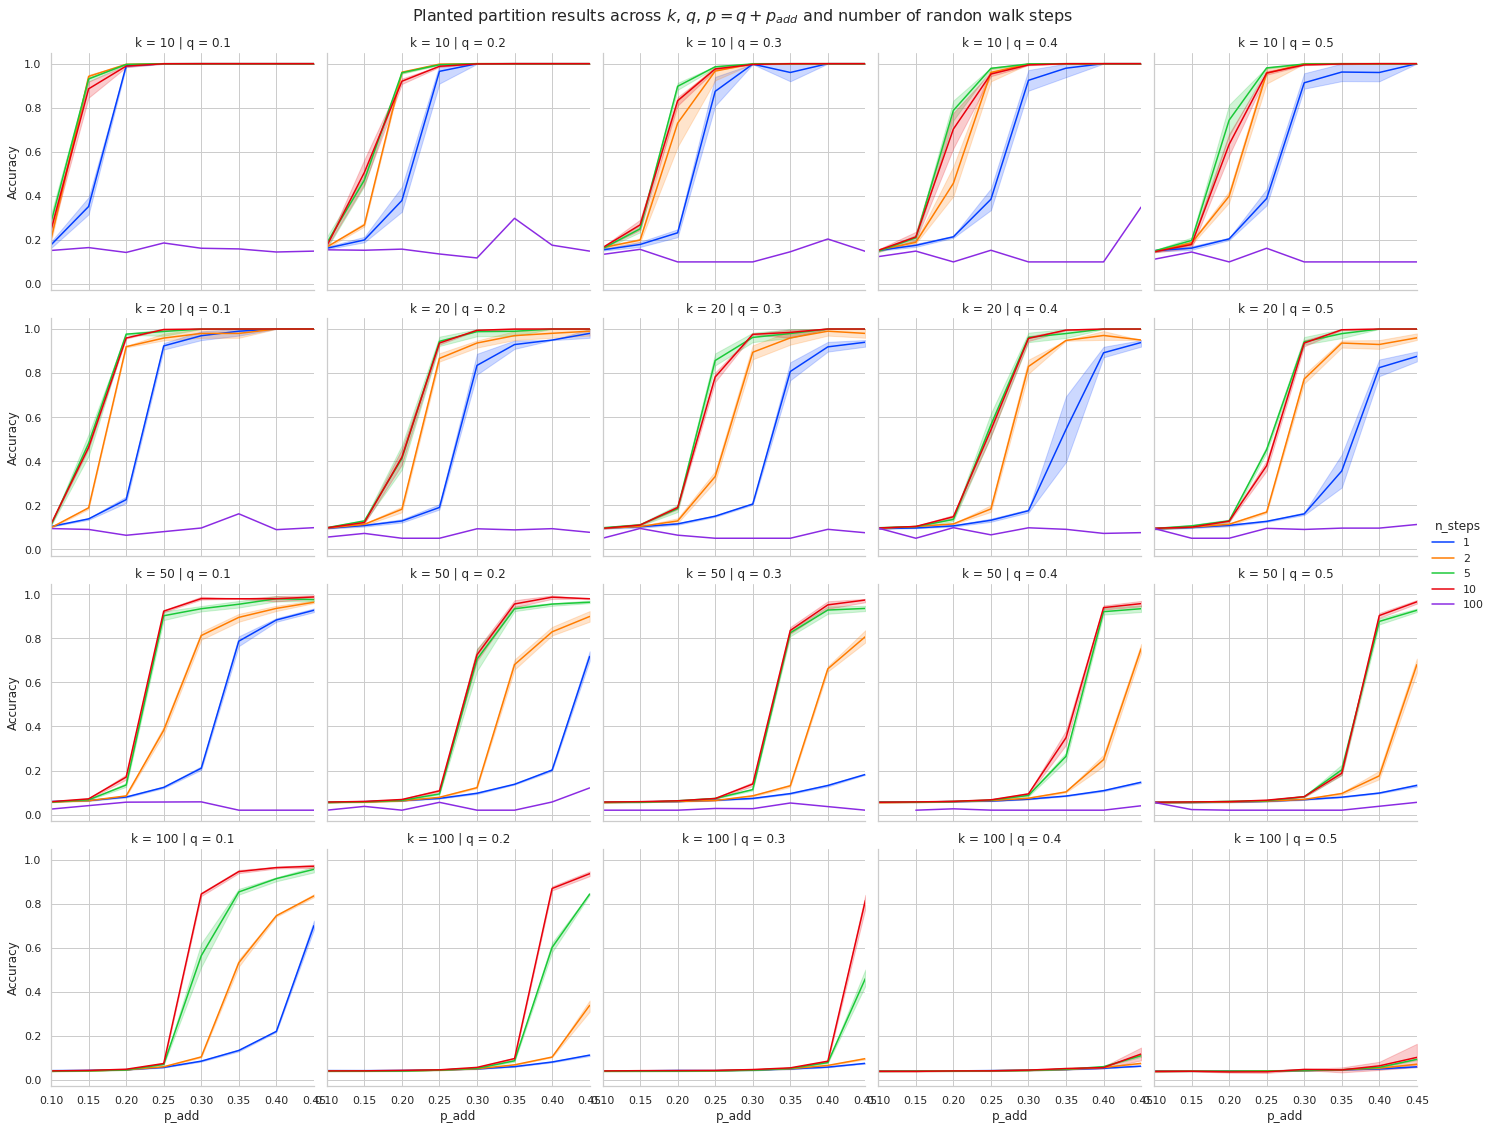

In [8]:
df_plot_data = df_data.copy()

# Initialize the FacetGrid object
pal = sns.color_palette("bright")

g = sns.FacetGrid(data=df_plot_data, row="k", col="q", hue="n_steps", height=4, palette=pal)

# Draw the densities in a few steps
g.map(sns.lineplot, "p_add", "accuracy_score")

x_min = df_plot_data.p_add.min()
x_max = df_plot_data.p_add.max()

g.set(ylabel="Accuracy", xlabel="p_add", xticks=df_plot_data.p_add.unique(), xlim=[x_min, x_max])
g.add_legend()

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Planted partition results across $k$, $q$, $p = q + p_{add}$ and number of randon walk steps", fontsize=16)

g.savefig("planted-partition-accuracy-plots.pdf")